In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

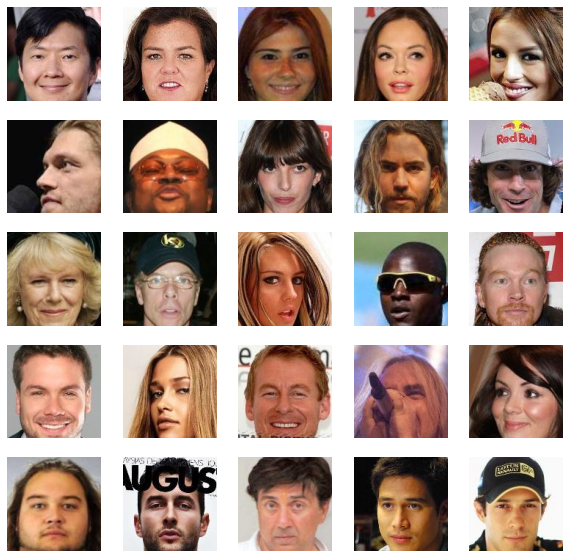

In [2]:
with open('CelebA16000_rand.bin','rb') as face:
    face = np.fromfile(face,dtype='uint8',count=-1)
    face = face.reshape(1,-1)
    face = np.transpose(face,[0,1])
    face = face.reshape(-1,218,3,178).transpose([0,1,3,2]).astype('float32') # imsize = [-1,218,178,3]
    train_images = face[:,45:173,25:153,:]/255
    
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(train_images[np.random.randint(0,face.shape[0]),:,:,:],cmap='viridis')

In [3]:
NUM_SAMPLES = train_images.shape[0]
BATCH_SIZE = 16
NUM_BATCHES = int(NUM_SAMPLES/BATCH_SIZE)
lr = 1e-4

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(16*16*16, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16,16,16)))
    
    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', activation='tanh'))
    
    return model

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = 0.5*tf.math.reduce_mean(tf.square(real_output-1))
    fake_loss = 0.5*tf.math.reduce_mean(tf.square(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

In [7]:
def generator_loss(fake_output):
    return 0.5*tf.math.reduce_mean(tf.square(fake_output-1))

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [10]:
checkpoint_dir = './training_checkpoints_LSGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
EPOCHS = 400
noise_dim = 256
num_examples_to_generate = 16

seed = tf.random.uniform([num_examples_to_generate, noise_dim],minval=-1,maxval=1)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim],minval=-1,maxval=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss

In [13]:
def train(dataset, epochs):
    dlossmat = []
    glossmat = []
    for epoch in range(epochs):
        start = time.time()

        for i in range(NUM_BATCHES):
            image_batch = train_images[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:,:,:]
            d_loss,g_loss = train_step(image_batch)
            dlossmat = np.append(dlossmat,[d_loss],axis=0)
            glossmat = np.append(glossmat,[g_loss],axis=0)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch + 1,seed)

        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)
    
    return dlossmat,glossmat

In [14]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('./LSGAN_pic_CelebA/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

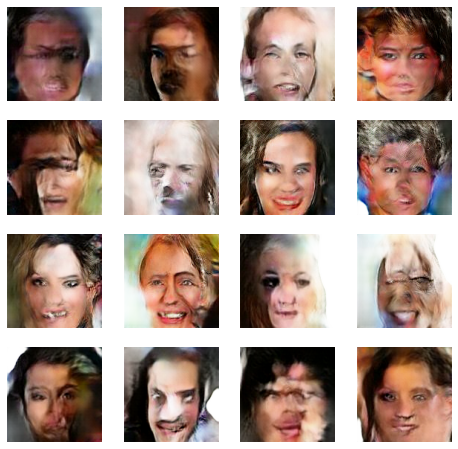

CPU times: user 11h 50min 32s, sys: 3min 52s, total: 11h 54min 25s
Wall time: 11h 41min 11s


In [15]:
%%time
dlossmat,glossmat = train(train_images, EPOCHS)

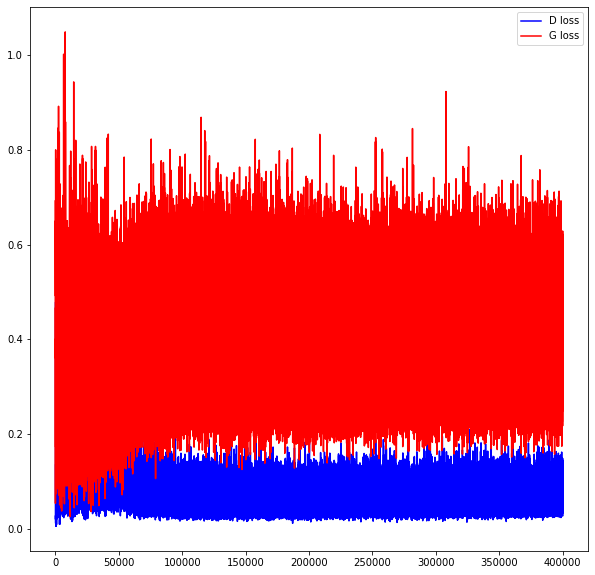

In [16]:
lossfig = plt.figure(figsize=(10,10))
axloss = lossfig.add_subplot(1,1,1)
axloss.plot(dlossmat[:],'b')
axloss.plot(glossmat[:],'r')
axloss.legend(['D loss', 'G loss'])

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [18]:
def display_image(epoch_no):
    return PIL.Image.open('./LSGAN_pic_CelebA/image_at_epoch_{:04d}.png'.format(epoch_no))

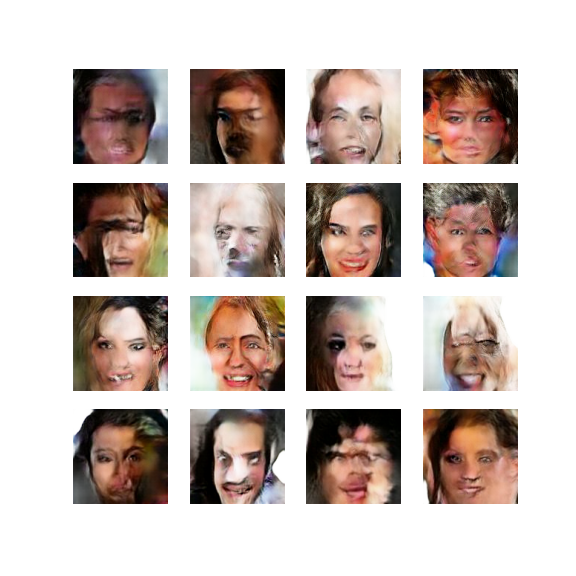

In [26]:
display_image(EPOCHS)

In [20]:
anim_file = 'LSGAN_CelebA.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./LSGAN_pic_CelebA/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

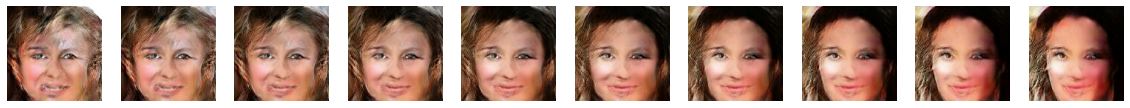

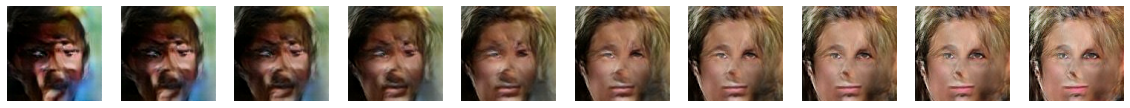

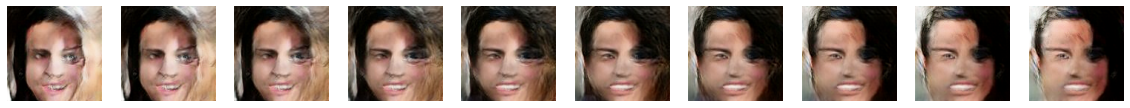

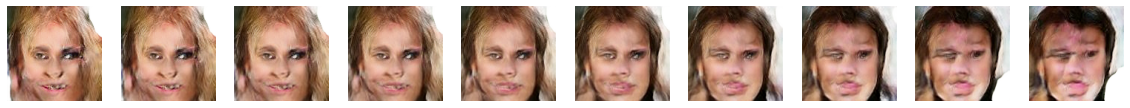

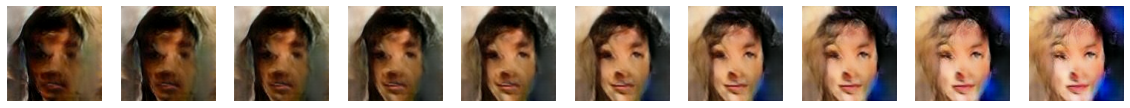

In [34]:
samp_num = 10
interp_tmp = np.linspace(0,1,num=samp_num)

for ii in range(5):
    lat_for_interp1 = np.random.uniform(low=-1,high=1,size=[1,noise_dim])
    lat_for_interp2 = np.random.uniform(low=-1,high=1,size=[1,noise_dim])

    for i in interp_tmp:
        L = (1-i)*lat_for_interp1 + i*lat_for_interp2
        if i==0:
            Latmat = L
        else:
            Latmat = np.append(Latmat,L,axis=0)

    int_image = generator(Latmat,training=False)

    intfig= plt.figure(figsize=(20,20))

    for ipnum in range(samp_num):
        intsubp = intfig.add_subplot(1,samp_num,ipnum+1)
        intsubp.imshow(int_image[ipnum,:,:,:])
        plt.axis('off')

    plt.savefig('./interpolation{:04d}.png'.format(ii+1))